In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [73]:
file_2009_2010 = "online_retail_II2009.csv"
file_2010_2011 = "online_retail_II2010.csv"

In [74]:
df_2009_2010 = pd.read_csv(file_2009_2010, sep=None, engine="python", encoding="latin1")
df_2010_2011 = pd.read_csv(file_2010_2011, sep=None, engine="python", encoding="latin1")

In [75]:
df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)
print(f"Nombre de lignes  : {len(df):,}")

Nombre de lignes  : 1,067,371


In [76]:
print(df['Price'].dtype)
print(df['Price'].isna().sum())
print(df['Price'].describe())


object
0
count     1067371
unique       2807
top          1,25
freq       104428
Name: Price, dtype: object


In [77]:
print("\nColonnes:", df.columns)


Colonnes: Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [ ]:
#  Vérification et correction des types de variables
# Vérification des types
print("Types de variables avant conversion :")
print(df.dtypes, "\n")


Types de variables avant conversion :
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price           object
Customer ID    float64
Country         object
dtype: object 



In [79]:
# Nettoyer les descriptions
df["Description"] = df["Description"].astype(str).str.strip().str.lower()

In [80]:
# Conversion du champ InvoiceDate en datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

In [81]:
# Conversion du champ Price en numérique (certaines valeurs sont texte)
df["Price"] = (
    df["Price"].astype(str)
    .str.replace(",", ".")           # pour corriger les virgules décimales
    .str.replace("£", "")            # pour enlever les symboles monétaires
    .str.replace("[^0-9.]", "", regex=True)  # enlever tout caractère non numérique
)

In [82]:
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")


In [83]:
# Conversion de Quantity en numérique au cas où
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")

In [84]:
print(df['Price'].head(10))
print(df['Price'].dtype)
print("Valeurs manquantes dans Price :", df['Price'].isna().sum())

0    6.95
1    6.75
2    6.75
3    2.10
4    1.25
5    1.65
6    1.25
7    5.95
8    2.55
9    3.75
Name: Price, dtype: float64
float64
Valeurs manquantes dans Price : 0


In [ ]:
#  Nettoyage de base
df = df.dropna(subset=['Description', 'StockCode', 'Quantity', 'Price'])
df = df[df['Price'] > 0]      # On garde seulement les prix positifs
df = df[df['Quantity'] != 0]  # Retirer les transactions nulles


In [ ]:
#  Agrégation par produit
produits = (
    df.groupby(['StockCode', 'Description'])
      .agg(
          prix_moyen=('Price', 'mean'),
          quantite_totale=('Quantity', 'sum'),
          nb_transactions=('Invoice', 'count'),
          taux_retour=('Quantity', lambda x: (x < 0).mean())
      )
      .reset_index()
)

In [87]:
produits

,StockCode,Description,prix_moyen,quantite_totale,nb_transactions,taux_retour
0,10002,inflatable political globe,0.984070,7613,398,0.017588
1,10002R,robot pencil sharpner,5.133333,4,3,0.000000
2,10080,groovy cactus inflatable,0.505000,315,28,0.000000
3,10109,bendy colour pencils,0.420000,4,1,0.000000
4,10120,doggy rubber,0.238205,650,78,0.012821
...,...,...,...,...,...,...
5611,gift_0001_40,dotcomgiftshop gift voucher £40.00,33.218000,5,5,0.000000
5612,gift_0001_50,dotcomgiftshop gift voucher £50.00,42.265000,6,6,0.000000
5613,gift_0001_70,dotcomgiftshop gift voucher £70.00,59.570000,1,1,0.000000
5614,gift_0001_80,dotcomgiftshop gift voucher £80.00,69.560000,0,2,0.500000


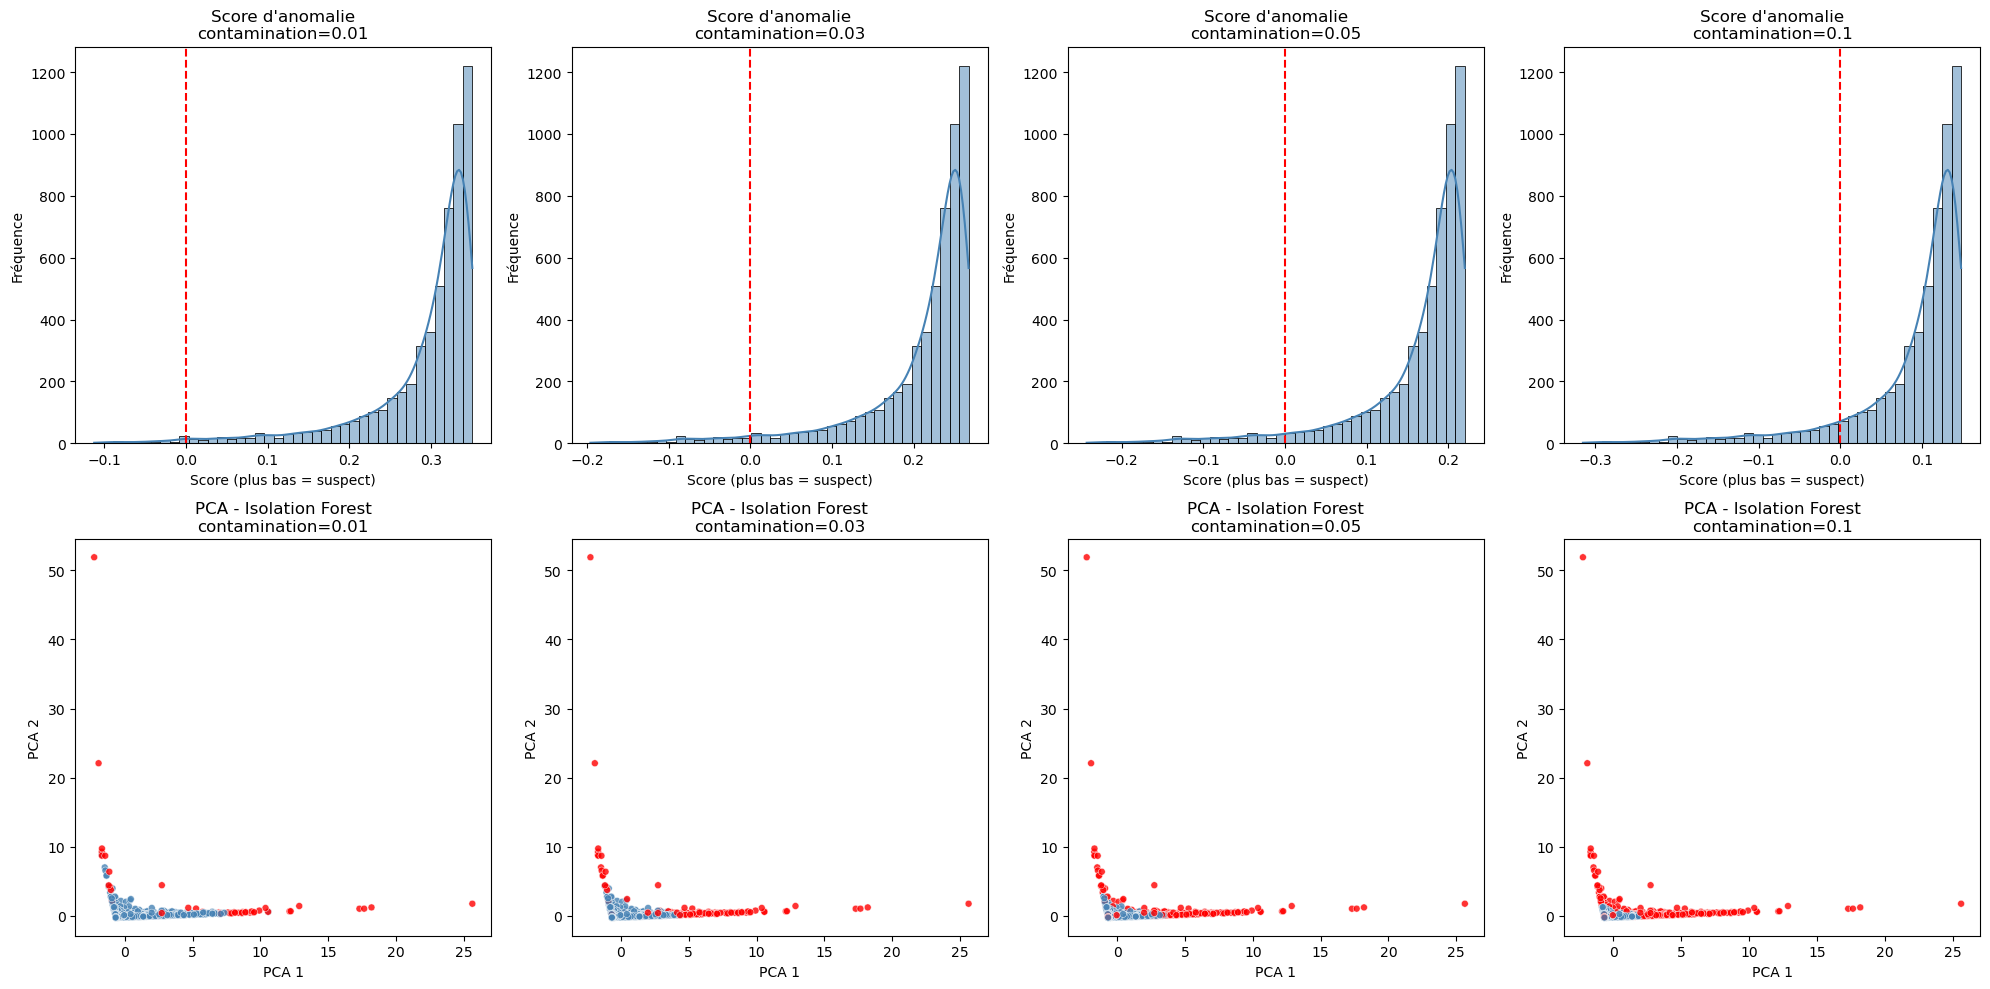

In [103]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Variables d’entrée
features = ['prix_moyen', 'quantite_totale', 'nb_transactions', 'taux_retour']
X = produits[features].fillna(0)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA pour projection 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
produits['pca1'] = X_pca[:, 0]
produits['pca2'] = X_pca[:, 1]

# Différents niveaux de contamination
contaminations = [0.01, 0.03, 0.05, 0.1]

# Figure globale
fig, axes = plt.subplots(2, len(contaminations), figsize=(5 * len(contaminations), 10))
plt.subplots_adjust(hspace=0.35)

for i, c in enumerate(contaminations):
    # Modèle Isolation Forest
    iso = IsolationForest(
        n_estimators=200,
        max_samples='auto',
        contamination=c,
        random_state=42,
        n_jobs=-1
    )
    iso.fit(X_scaled)
    
    # Prédictions et score
    produits[f'anomaly_{int(c*100)}'] = np.where(iso.predict(X_scaled) == -1, 1, 0)
    produits[f'score_{int(c*100)}'] = iso.decision_function(X_scaled)
    
    # ----------------------------
    # 1️⃣ Histogramme du score
    # ----------------------------
    ax1 = axes[0, i]
    sns.histplot(
        produits[f'score_{int(c*100)}'],
        bins=40, kde=True, color='steelblue', ax=ax1
    )
    seuil = produits.loc[produits[f'anomaly_{int(c*100)}'] == 1, f'score_{int(c*100)}'].max()
    ax1.axvline(seuil, color='red', linestyle='--')
    ax1.set_title(f"Score d'anomalie\ncontamination={c}", fontsize=12)
    ax1.set_xlabel("Score (plus bas = suspect)")
    ax1.set_ylabel("Fréquence")
    
    # ----------------------------
    # 2️⃣ Scatter PCA (normal vs anomalie)
    # ----------------------------
    ax2 = axes[1, i]
    sns.scatterplot(
        data=produits,
        x='pca1', y='pca2',
        hue=f'anomaly_{int(c*100)}',
        palette={0: 'steelblue', 1: 'red'},
        s=25, alpha=0.8, ax=ax2
    )
    ax2.set_title(f"PCA - Isolation Forest\ncontamination={c}", fontsize=12)
    ax2.set_xlabel("PCA 1")
    ax2.set_ylabel("PCA 2")
    ax2.legend_.remove()  # on garde le graphe propre

plt.tight_layout()
plt.show()


Le taux contamination = 0.03 est visuellement le plus pertinent pour ton dataset :
il isole clairement les points aberrants sans englober une trop grande partie du nuage principal.

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# On suppose que le DataFrame "produits" est déjà créé :
# colonnes : prix_moyen, quantite_totale, nb_transactions, taux_retour

features = ['prix_moyen', 'quantite_totale', 'nb_transactions', 'taux_retour']
X = produits[features].fillna(0)

#  Étape 1 : Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Étape 2 : Modèle Isolation Forest
iso = IsolationForest(
    n_estimators=200,       # nombre d'arbres (200 = bonne robustesse)
    max_samples='auto',     # nombre d'échantillons utilisés par arbre
    contamination=0.03,     # ≈ 3% d’anomalies attendues
    random_state=42,        # reproductibilité
    n_jobs=-1               # parallélisation
)

#  Étape 3 : Ajustement du modèle
iso.fit(X_scaled)

#  Étape 4 : Prédiction
# 1 = normal, -1 = anomalie
produits['anomaly_iforest'] = iso.predict(X_scaled)
produits['anomaly_iforest'] = produits['anomaly_iforest'].map({1: 0, -1: 1})

#  Étape 5 : Score d’anomalie (plus petit = plus suspect)
produits['score_iforest'] = iso.decision_function(X_scaled)

#  Étape 6 : Visualisation des produits les plus suspects
anomalies = produits[produits['anomaly_iforest'] == 1].sort_values('score_iforest')
print("Produits suspects :")
print(anomalies[['StockCode', 'Description', 'prix_moyen', 'quantite_totale', 'taux_retour', 'score_iforest']].head(10))


Produits suspects :
         StockCode                          Description   prix_moyen  \
5578     AMAZONFEE                           amazon fee  7646.089302   
5582          CRUK                      cruk commission   495.839375   
5601             M                               manual   531.393989   
5576        ADJUST  adjustment by peter on 24/05/2010 1   243.683333   
4983        85123A   white hanging heart t-light holder     3.067278   
5580  BANK CHARGES                         bank charges   359.034422   
4952        85099B              jumbo bag red retrospot     2.357041   
691          21232       strawberry ceramic trinket box     1.497354   
4625         84879        assorted colour bird ornament     1.854508   
5583             D                             discount    72.867288   

      quantite_totale  taux_retour  score_iforest  
5578              -35     0.906977      -0.195833  
5582              -16     1.000000      -0.188508  
5601             4600     0.379

In [46]:
produits.head()

,StockCode,Description,prix_moyen,quantite_totale,nb_transactions,taux_retour,pca1,pca2,anomaly_1,score_1,anomaly_3,score_3,anomaly_5,score_5,anomaly_10,score_10,anomaly_iforest,score_iforest
0,10002,inflatable political globe,0.984070,7613,398,0.017588,1.291118,0.017479,0,0.238256,0,0.154934,0,0.107829,0,0.035442,0,0.154934
1,10002R,robot pencil sharpner,5.133333,4,3,0.000000,-0.672391,-0.270504,0,0.337223,0,0.253900,0,0.206796,0,0.134408,0,0.253900
2,10080,groovy cactus inflatable,0.505000,315,28,0.000000,-0.571357,-0.272095,0,0.339455,0,0.256132,0,0.209028,0,0.136640,0,0.256132
3,10109,bendy colour pencils,0.420000,4,1,0.000000,-0.676601,-0.279515,0,0.331474,0,0.248151,0,0.201047,0,0.128660,0,0.248151
4,10120,doggy rubber,0.238205,650,78,0.012821,-0.424072,-0.144772,0,0.324854,0,0.241531,0,0.194427,0,0.122040,0,0.241531


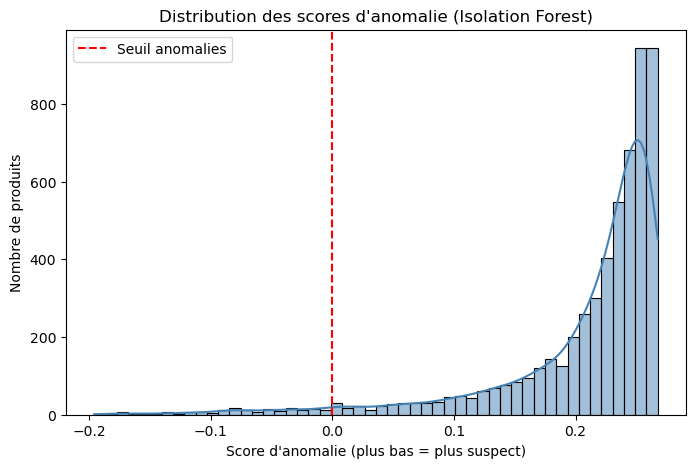

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(
    produits['score_iforest'],
    bins=50,
    kde=True,
    color='steelblue'
)

plt.title("Distribution des scores d'anomalie (Isolation Forest)")
plt.xlabel("Score d'anomalie (plus bas = plus suspect)")
plt.ylabel("Nombre de produits")
plt.axvline(
    produits.loc[produits['anomaly_iforest'] == 1, 'score_iforest'].max(),
    color='red',
    linestyle='--',
    label='Seuil anomalies'
)
plt.legend()
plt.show()


Le premier graphique montre la distribution des scores d’anomalie.

Le seuil (en rouge) sépare les produits considérés comme normaux (à droite, score > 0) des suspects/anormaux (à gauche, score < 0).

La plupart des produits sont normaux (fort score, zone de confiance élevée).

Une minorité (~3%) est détectée comme anormale, donc potentiellement problématique ou inhabituelle.

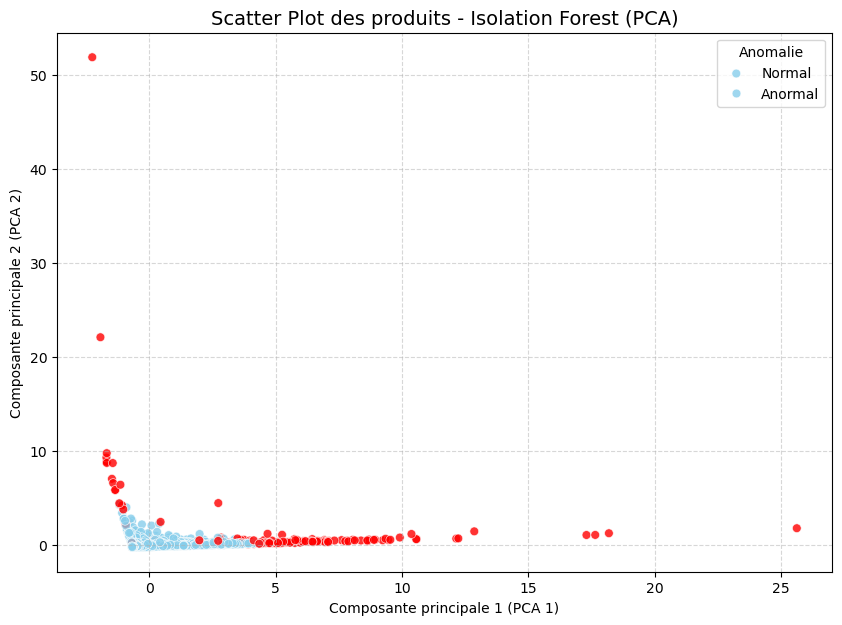

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=produits,
    x='pca1',
    y='pca2',
    hue='anomaly_iforest',
    palette={0: 'skyblue', 1: 'red'},  # bleu = normal, rouge = anomalie
    s=40,
    alpha=0.8
)

plt.title("Scatter Plot des produits - Isolation Forest (PCA)", fontsize=14)
plt.xlabel("Composante principale 1 (PCA 1)")
plt.ylabel("Composante principale 2 (PCA 2)")
plt.legend(title="Anomalie", labels=["Normal", "Anormal"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Les points rouges représentent les produits anormaux selon l’Isolation Forest.

Cela confirme qu’ils ont des comportements ou caractéristiques très différentes du reste du catalogue.

L’analyse PCA montre une nette séparation entre les produits normaux et anormaux.
Les anomalies détectées par Isolation Forest se situent principalement dans des zones éloignées du nuage principal, indiquant des comportements atypiques en termes de prix, de quantités vendues ou de retours clients.
Cette séparation valide la pertinence du modèle : il isole efficacement les produits extrêmes par rapport au comportement général.

In [107]:
anomalies = produits[produits['anomaly_iforest'] == 1]
normaux = produits[produits['anomaly_iforest'] == 0]

print(f"Produits anormaux : {len(anomalies)} / {len(produits)} ({len(anomalies)/len(produits)*100:.2f}%)")


Produits anormaux : 169 / 5616 (3.01%)


In [108]:
comparaison = produits.groupby('anomaly_iforest')[['prix_moyen', 'quantite_totale', 'nb_transactions', 'taux_retour']].mean()
print(comparaison)

                 prix_moyen  quantite_totale  nb_transactions  taux_retour
anomaly_iforest                                                           
0                  4.033375      1461.703139       160.526528     0.018092
1                244.591348     17558.704142      1105.213018     0.187627


In [51]:
produits

,StockCode,Description,prix_moyen,quantite_totale,nb_transactions,taux_retour,pca1,pca2,anomaly_1,score_1,anomaly_3,score_3,anomaly_5,score_5,anomaly_10,score_10,anomaly_iforest,score_iforest
0,10002,inflatable political globe,0.984070,7613,398,0.017588,1.291118,0.017479,0,0.238256,0,0.154934,0,0.107829,0,0.035442,0,0.154934
1,10002R,robot pencil sharpner,5.133333,4,3,0.000000,-0.672391,-0.270504,0,0.337223,0,0.253900,0,0.206796,0,0.134408,0,0.253900
2,10080,groovy cactus inflatable,0.505000,315,28,0.000000,-0.571357,-0.272095,0,0.339455,0,0.256132,0,0.209028,0,0.136640,0,0.256132
3,10109,bendy colour pencils,0.420000,4,1,0.000000,-0.676601,-0.279515,0,0.331474,0,0.248151,0,0.201047,0,0.128660,0,0.248151
4,10120,doggy rubber,0.238205,650,78,0.012821,-0.424072,-0.144772,0,0.324854,0,0.241531,0,0.194427,0,0.122040,0,0.241531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,gift_0001_40,dotcomgiftshop gift voucher £40.00,33.218000,5,5,0.000000,-0.669349,-0.218374,0,0.172737,0,0.089414,0,0.042310,1,-0.030077,0,0.089414
5612,gift_0001_50,dotcomgiftshop gift voucher £50.00,42.265000,6,6,0.000000,-0.667476,-0.201518,0,0.146834,0,0.063511,0,0.016407,1,-0.055980,0,0.063511
5613,gift_0001_70,dotcomgiftshop gift voucher £70.00,59.570000,1,1,0.000000,-0.680352,-0.170440,0,0.099639,0,0.016317,1,-0.030788,1,-0.103175,0,0.016317
5614,gift_0001_80,dotcomgiftshop gift voucher £80.00,69.560000,0,2,0.500000,-1.181450,4.398434,1,-0.030888,1,-0.114211,1,-0.161315,1,-0.233703,1,-0.114211


DBSCAN

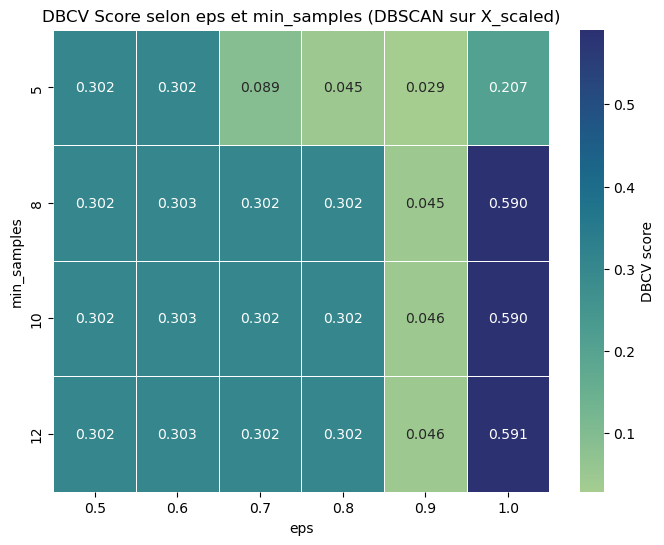


🔥 Meilleurs paramètres DBSCAN : eps=1.0, min_samples=12.0
➡️ DBCV score = 0.591


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from hdbscan.validity import validity_index
import itertools

# ----------------------------
#  Données d'entrée : features normalisées
# ----------------------------
features = ['prix_moyen', 'quantite_totale', 'nb_transactions', 'taux_retour']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(produits[features])

# ----------------------------
# Paramètres à tester
# ----------------------------
eps_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_samples_values = [5, 8, 10, 12]

results = []

# ----------------------------
# Grid search DBCV
# ----------------------------
for eps, ms in itertools.product(eps_values, min_samples_values):
    db = DBSCAN(eps=eps, min_samples=ms, n_jobs=-1).fit(X_scaled)
    labels = db.labels_
    mask = labels != -1  # Exclure le bruit
    
    # DBCV uniquement si au moins 2 clusters valides
    if len(np.unique(labels[mask])) >= 2:
        try:
            dbcv = validity_index(X_scaled[mask], labels[mask])
        except:
            dbcv = np.nan
    else:
        dbcv = np.nan
    
    results.append((eps, ms, dbcv))

# ----------------------------
# Résultats → DataFrame
# ----------------------------
df_results = pd.DataFrame(results, columns=['eps', 'min_samples', 'DBCV'])

# Pivot pour la heatmap
pivot_dbcv = df_results.pivot_table(index='min_samples', columns='eps', values='DBCV')

# ----------------------------
#  Heatmap DBCV
# ----------------------------
plt.figure(figsize=(8,6))
sns.heatmap(pivot_dbcv, annot=True, fmt=".3f", cmap="crest", linewidths=0.5, cbar_kws={'label': 'DBCV score'})
plt.title("DBCV Score selon eps et min_samples (DBSCAN sur X_scaled)")
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.show()

# ----------------------------
# 🔥 Meilleurs paramètres
# ----------------------------
best = df_results.loc[df_results['DBCV'].idxmax()]
print(f"\n🔥 Meilleurs paramètres DBSCAN : eps={best.eps}, min_samples={best.min_samples}")
print(f"➡️ DBCV score = {best.DBCV:.3f}")


In [23]:
from sklearn.cluster import DBSCAN
import itertools

eps_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_samples_values = [5, 8, 10, 12]

results = []

for eps, ms in itertools.product(eps_values, min_samples_values):
    db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    n_anomalies = np.sum(db.labels_ == -1)
    results.append((eps, ms, n_clusters, n_anomalies / len(X_scaled)))

results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters', 'pct_anomalies'])
print(results_df)


    eps  min_samples  n_clusters  pct_anomalies
0   0.5            5           3       0.020299
1   0.5            8           3       0.022080
2   0.5           10           3       0.023148
3   0.5           12           3       0.024751
4   0.6            5           3       0.017272
5   0.6            8           3       0.018875
6   0.6           10           3       0.019231
7   0.6           12           3       0.019943
8   0.7            5           6       0.011930
9   0.7            8           3       0.016560
10  0.7           10           3       0.016916
11  0.7           12           3       0.017272
12  0.8            5           3       0.011396
13  0.8            8           3       0.015491
14  0.8           10           3       0.015670
15  0.8           12           3       0.015848
16  0.9            5           3       0.009081
17  0.9            8           3       0.011752
18  0.9           10           3       0.014067
19  0.9           12           3       0

Nombre de clusters : 2
Nombre d'anomalies détectées : 72 / 5616 (1.28%)

Moyennes par type de produit :

            prix_moyen  quantite_totale  nb_transactions  taux_retour
is_anomaly                                                           
0                 4.62          1600.10           171.78         0.02
1               523.26         28588.53          1511.74         0.09


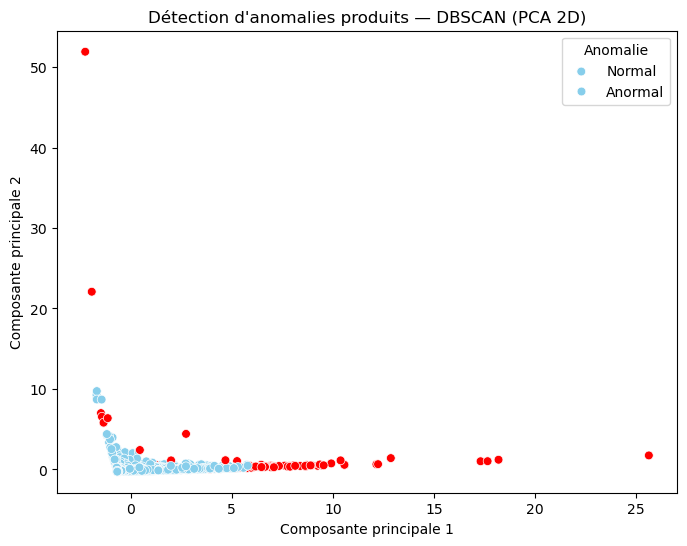

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

#  Sélection des variables numériques
features = ['prix_moyen', 'quantite_totale', 'nb_transactions', 'taux_retour']
X = produits[features]

#  Normalisation (indispensable pour DBSCAN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Entraînement DBSCAN
db = DBSCAN(eps=1.0, min_samples=12).fit(X_scaled)
labels = db.labels_

#  Ajout des résultats au DataFrame produits
produits['cluster_dbscan'] = labels
produits['is_anomaly'] = (labels == -1).astype(int)

#  Statistiques globales
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_anomalies = np.sum(produits['is_anomaly'] == 1)

print(f"Nombre de clusters : {n_clusters}")
print(f"Nombre d'anomalies détectées : {n_anomalies} / {len(produits)} ({n_anomalies/len(produits)*100:.2f}%)")

#  Comparaison entre produits normaux et anormaux
stats = produits.groupby('is_anomaly')[features].mean().round(2)
print("\nMoyennes par type de produit :\n")
print(stats)

#  Visualisation PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=produits['is_anomaly'],
                palette={0:"skyblue", 1:"red"}, s=40)
plt.title("Détection d'anomalies produits — DBSCAN (PCA 2D)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend(title="Anomalie", labels=["Normal", "Anormal"])
plt.show()


Nombre de clusters détectés : 2
Nombre de points considérés comme bruit (anomalies) : 72


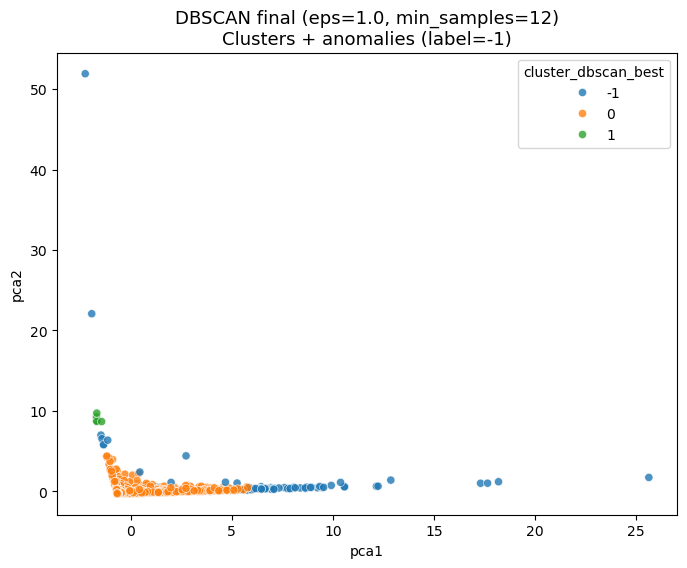

In [58]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Meilleurs paramètres trouvés
best_eps = 1.0
best_min_samples = 12

# Entraînement final
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1)
labels = dbscan.fit_predict(X_scaled)
produits['cluster_dbscan_best'] = labels

# Statistiques
n_clusters = len(np.unique(labels[labels != -1]))
n_noise = (labels == -1).sum()
print(f"Nombre de clusters détectés : {n_clusters}")
print(f"Nombre de points considérés comme bruit (anomalies) : {n_noise}")

# Projection PCA 2D pour visualiser les clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
produits['pca1'], produits['pca2'] = X_pca[:,0], X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=produits,
    x='pca1', y='pca2',
    hue='cluster_dbscan_best',
    palette='tab10', s=35, alpha=0.8
)
plt.title(f"DBSCAN final (eps={best_eps}, min_samples={best_min_samples})\nClusters + anomalies (label=-1)", fontsize=13)
plt.show()


In [110]:
print(produits['cluster_dbscan'].value_counts())


cluster_dbscan
 0    5526
-1      72
 1      18
Name: count, dtype: int64


1. Analyse du chevauchement entre DBSCAN et Isolation Forest

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

# Vérification des colonnes
assert "anomaly_iforest" in produits.columns, "Colonne 'anomaly_iforest' manquante"
assert "is_anomaly" in produits.columns, "Colonne 'is_anomaly' manquante"

# Catégorisation du type d'anomalie
produits["source_anomalie"] = produits.apply(
    lambda x: "Les deux" if x["is_anomaly"] == 1 and x["anomaly_iforest"] == 1
    else "DBSCAN seul" if x["is_anomaly"] == 1
    else "Isolation Forest seul" if x["anomaly_iforest"] == 1
    else "Aucune",
    axis=1
)

# Comptage et pourcentage
overlap_counts = produits["source_anomalie"].value_counts()
overlap_pct = produits["source_anomalie"].value_counts(normalize=True) * 100

result_overlap = pd.DataFrame({
    "Nombre": overlap_counts,
    "Pourcentage": overlap_pct.round(2)
})

print("=== Répartition des anomalies ===")
print(result_overlap)


=== Répartition des anomalies ===
                       Nombre  Pourcentage
source_anomalie                           
Aucune                   5445        96.96
Isolation Forest seul      99         1.76
Les deux                   70         1.25
DBSCAN seul                 2         0.04


2. Visualisation du chevauchement

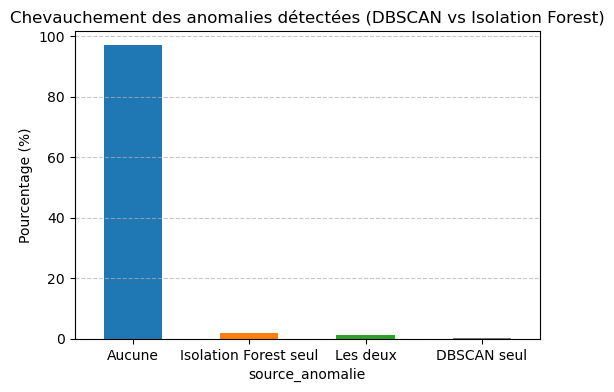

In [112]:
plt.figure(figsize=(6,4))
result_overlap["Pourcentage"].plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#7f7f7f'])
plt.title("Chevauchement des anomalies détectées (DBSCAN vs Isolation Forest)")
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


aucune cad produit considéré comme normal pour dbscan et isolation forest

3. Produits détectés par les deux modèles

In [113]:
# Filtrer les anomalies communes
anomalies_communes = produits[(produits["is_anomaly"] == 1) & (produits["anomaly_iforest"] == 1)]

print(f"\nNombre d'anomalies communes : {len(anomalies_communes)}")
print("\nTop 10 des produits les plus suspects :")

display(
    anomalies_communes[
        ["StockCode", "Description", "prix_moyen", "quantite_totale",
         "nb_transactions", "taux_retour", "score_iforest", "pca1","pca2"]
    ]
    .sort_values("score_iforest")
    .head(10)
)



Nombre d'anomalies communes : 70

Top 10 des produits les plus suspects :


,StockCode,Description,prix_moyen,quantite_totale,nb_transactions,taux_retour,score_iforest,pca1,pca2
5578,AMAZONFEE,amazon fee,7646.089302,-35,43,0.906977,-0.195833,-1.929036,22.083486
5601,M,manual,531.393989,4600,1414,0.379774,-0.184469,2.735366,4.424195
4983,85123A,white hanging heart t-light holder,3.067278,92448,5812,0.023228,-0.176758,25.630899,1.744398
5580,BANK CHARGES,bank charges,359.034422,-42,102,0.656863,-0.172401,-1.137752,6.375380
4952,85099B,jumbo bag red retrospot,2.357041,77665,3440,0.021512,-0.171387,18.194779,1.209594
691,21232,strawberry ceramic trinket box,1.497354,36682,2611,0.070471,-0.169457,10.380533,1.129281
4625,84879,assorted colour bird ornament,1.854508,81298,2957,0.006425,-0.169036,17.653536,1.029595
1883,22423,regency cakestand 3 tier,14.007942,26109,4408,0.078721,-0.166572,12.866293,1.411084
4786,84991,60 teatime fairy cake cases,0.663214,54366,2271,0.006165,-0.156587,12.235146,0.658092
1381,21977,pack of 60 pink paisley cake cases,0.710860,56575,2092,0.005258,-0.156074,12.154248,0.642714


Combined anomaly detection Isolation Forest + DBSCAN

In [115]:
from sklearn.preprocessing import MinMaxScaler

# --- Normaliser le score Isolation Forest ---
# (plus le score est bas, plus le point est suspect → on inverse)
scaler = MinMaxScaler()
produits["score_iforest_norm"] = scaler.fit_transform(-produits["score_iforest"].values.reshape(-1, 1))

# --- Créer le score DBSCAN (binaire mais compatible avec le reste) ---
produits["score_dbscan"] = produits["is_anomaly"]

# --- Calcul du score combiné (moyenne des deux) ---
produits["score_combined"] = produits[["score_iforest_norm", "score_dbscan"]].mean(axis=1)


In [116]:
threshold = produits["score_combined"].quantile(0.98)

# Créer une colonne binaire finale
produits["is_anomaly_vote"] = (produits["score_combined"] >= threshold).astype(int)

print(f"Seuil retenu : {threshold:.3f}")
print(produits["is_anomaly_vote"].value_counts())


Seuil retenu : 0.340
is_anomaly_vote
0    5503
1     113
Name: count, dtype: int64


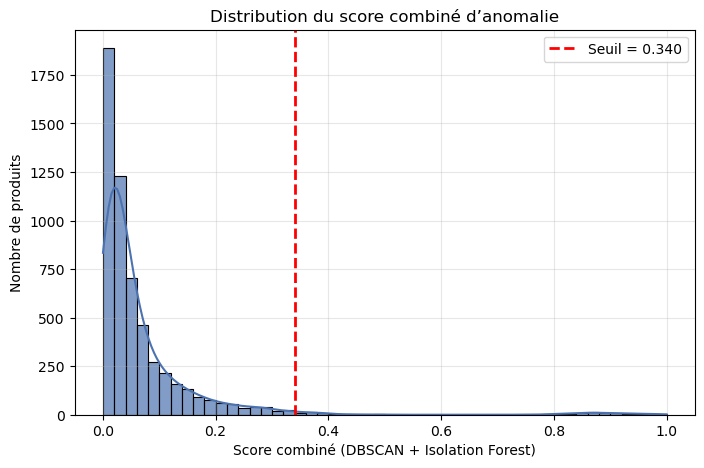

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(produits["score_combined"], bins=50, kde=True, color="#4C72B0", alpha=0.7)
plt.axvline(threshold, color="red", linestyle="--", linewidth=2, label=f"Seuil = {threshold:.3f}")
plt.title("Distribution du score combiné d’anomalie")
plt.xlabel("Score combiné (DBSCAN + Isolation Forest)")
plt.ylabel("Nombre de produits")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


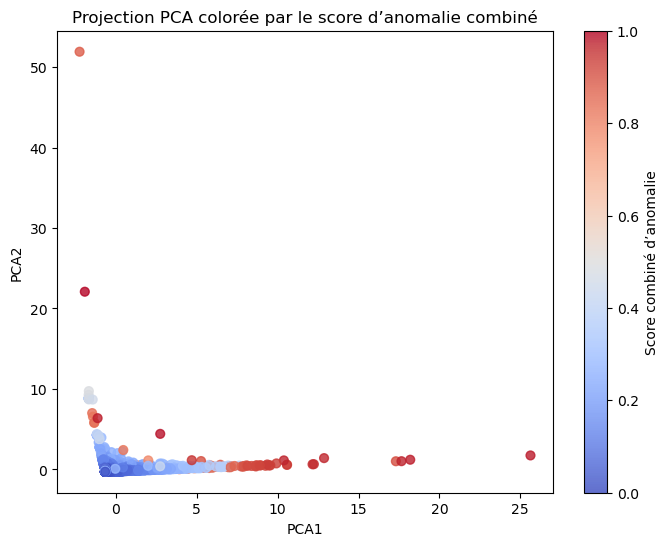

In [44]:
plt.figure(figsize=(8,6))
plt.scatter(
    produits["pca1"],produits["pca2"],
    c=produits["score_combined"], cmap="coolwarm", s=40, alpha=0.8
)
plt.colorbar(label="Score combiné d’anomalie")
plt.title("Projection PCA colorée par le score d’anomalie combiné")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

Afin d’augmenter la robustesse de la détection d’anomalies, deux algorithmes complémentaires ont été utilisés :
DBSCAN, fondé sur la densité des points dans l’espace PCA, et Isolation Forest, fondé sur l’isolement statistique des observations.

Chacun présentant des avantages distincts (DBSCAN : forte précision / Isolation Forest : forte sensibilité), une fusion des résultats a été mise en place.
Les scores des deux modèles ont été normalisés et combinés sous la forme d’un score global d’anomalie, défini comme la moyenne des deux indices.
Un seuil adaptatif (98ᵉ percentile) a permis d’identifier les observations les plus suspectes (≈ 2 % du jeu de données).

Cette approche “vote pondéré” permet de réduire les faux négatifs tout en conservant une bonne précision, conformément aux recommandations de la littérature scientifique.
Les résultats ont ensuite été validés visuellement à l’aide de la projection PCA colorée par le score combiné.

In [118]:
# Extraire uniquement les anomalies finales
anomalies_finales = produits[produits["is_anomaly_vote"] == 1].copy()

print(f"Nombre d'anomalies détectées : {len(anomalies_finales)}")
display(anomalies_finales.head(10))  # affiche les 10 premières anomalies


Nombre d'anomalies détectées : 113


,StockCode,Description,prix_moyen,quantite_totale,nb_transactions,taux_retour,pca1,pca2,anomaly_1,score_1,...,is_anomaly_iqr,anomaly_iforest,score_iforest,cluster_dbscan,is_anomaly,source_anomalie,score_iforest_norm,score_dbscan,score_combined,is_anomaly_vote
17,15036,assorted colours silk fan,0.989843,43436,1017,0.013766,7.846102,0.424232,1,-0.001982,...,1,1,-0.085305,-1,1,Les deux,0.761451,1,0.880725,1
42,16014,small chinese style scissor,0.395258,30370,97,0.000000,3.917638,0.026716,0,0.070038,...,1,1,-0.013285,-1,1,Les deux,0.606012,1,0.803006,1
120,17003,brocade ring purse,0.658983,70690,482,0.012448,10.581402,0.588005,0,0.010948,...,1,1,-0.072375,-1,1,Les deux,0.733545,1,0.866772,1
280,20719,woodland charlotte bag,1.148315,24810,1638,0.010379,6.552275,0.313657,0,0.010957,...,1,1,-0.072366,0,0,Isolation Forest seul,0.733526,0,0.366763,1
285,20725,lunch bag red retrospot,2.114229,22203,1984,0.026210,6.934268,0.489397,1,-0.015099,...,1,1,-0.098422,-1,1,Les deux,0.789762,1,0.894881,1
287,20726,lunch bag woodland,2.100655,21326,2047,0.018564,6.956392,0.421375,1,-0.006969,...,1,1,-0.090292,-1,1,Les deux,0.772214,1,0.886107,1
288,20727,lunch bag black skull.,2.012036,25915,2529,0.017794,8.697179,0.534630,1,-0.027128,...,1,1,-0.110451,-1,1,Les deux,0.815723,1,0.907861,1
289,20728,lunch bag cars blue,1.965224,23752,2184,0.019689,7.611605,0.476343,1,-0.018554,...,1,1,-0.101876,-1,1,Les deux,0.797217,1,0.898609,1
335,20779,pink ear muff headphones,5.070000,-3,2,1.000000,-1.680893,8.829749,0,0.000495,...,1,1,-0.082828,1,0,Isolation Forest seul,0.756105,0,0.378052,1
516,21034,rex cash+carry jumbo shopper,0.950000,4212,2198,0.004095,4.840522,0.147489,0,0.060658,...,1,1,-0.022665,-1,1,Les deux,0.626258,1,0.813129,1


In [119]:
# --- Séparation des données ---
produits_clean = produits[produits["is_anomaly_vote"] == 0].copy()
anomalies_finales = produits[produits["is_anomaly_vote"] == 1].copy()

print(f"✅ Données normales : {len(produits_clean)} produits")
print(f"⚠️ Anomalies détectées : {len(anomalies_finales)} produits")

✅ Données normales : 5503 produits
⚠️ Anomalies détectées : 113 produits


In [50]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15cm christmas glass ball 20 lights,12,2009-01-12 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,pink cherry lights,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,white cherry lights,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"record frame 7"" single size",48,2009-01-12 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,strawberry ceramic trinket box,24,2009-01-12 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,children's apron dolly girl,6,2011-09-12 12:50:00,2.10,12680.0,France
1067367,581587,23254,childrens cutlery dolly girl,4,2011-09-12 12:50:00,4.15,12680.0,France
1067368,581587,23255,childrens cutlery circus parade,4,2011-09-12 12:50:00,4.15,12680.0,France
1067369,581587,22138,baking set 9 piece retrospot,3,2011-09-12 12:50:00,4.95,12680.0,France


In [51]:
produits

,StockCode,Description,prix_moyen,quantite_totale,nb_transactions,taux_retour,pca1,pca2,anomaly_1,score_1,...,score_10,anomaly_iforest,score_iforest,cluster_dbscan,is_anomaly,source_anomalie,score_iforest_norm,score_dbscan,score_combined,is_anomaly_vote
0,10002,inflatable political globe,0.984070,7613,398,0.017588,1.291118,0.017479,0,0.238256,...,0.035442,0,0.154934,0,0,Aucune,0.242952,0,0.121476,0
1,10002R,robot pencil sharpner,5.133333,4,3,0.000000,-0.672391,-0.270504,0,0.337223,...,0.134408,0,0.253900,0,0,Aucune,0.029356,0,0.014678,0
2,10080,groovy cactus inflatable,0.505000,315,28,0.000000,-0.571357,-0.272095,0,0.339455,...,0.136640,0,0.256132,0,0,Aucune,0.024538,0,0.012269,0
3,10109,bendy colour pencils,0.420000,4,1,0.000000,-0.676601,-0.279515,0,0.331474,...,0.128660,0,0.248151,0,0,Aucune,0.041763,0,0.020882,0
4,10120,doggy rubber,0.238205,650,78,0.012821,-0.424072,-0.144772,0,0.324854,...,0.122040,0,0.241531,0,0,Aucune,0.056050,0,0.028025,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,gift_0001_40,dotcomgiftshop gift voucher £40.00,33.218000,5,5,0.000000,-0.669349,-0.218374,0,0.172737,...,-0.030077,0,0.089414,0,0,Aucune,0.384360,0,0.192180,0
5612,gift_0001_50,dotcomgiftshop gift voucher £50.00,42.265000,6,6,0.000000,-0.667476,-0.201518,0,0.146834,...,-0.055980,0,0.063511,0,0,Aucune,0.440266,0,0.220133,0
5613,gift_0001_70,dotcomgiftshop gift voucher £70.00,59.570000,1,1,0.000000,-0.680352,-0.170440,0,0.099639,...,-0.103175,0,0.016317,0,0,Aucune,0.542125,0,0.271062,0
5614,gift_0001_80,dotcomgiftshop gift voucher £80.00,69.560000,0,2,0.500000,-1.181450,4.398434,1,-0.030888,...,-0.233703,1,-0.114211,0,0,Isolation Forest seul,0.823839,0,0.411919,1


In [49]:
print(df.columns)
print(produits.columns)


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
Index(['StockCode', 'Description', 'prix_moyen', 'quantite_totale',
       'nb_transactions', 'taux_retour', 'pca1', 'pca2', 'anomaly_1',
       'score_1', 'anomaly_3', 'score_3', 'anomaly_5', 'score_5', 'anomaly_10',
       'score_10', 'anomaly_iforest', 'score_iforest', 'cluster_dbscan',
       'is_anomaly', 'source_anomalie', 'score_iforest_norm', 'score_dbscan',
       'score_combined', 'is_anomaly_vote'],
      dtype='object')


In [52]:
# Extraire les codes des produits anormaux
codes_anormaux = produits.loc[produits["is_anomaly_vote"] == 1, "StockCode"].unique()

# Supprimer ces produits du dataset initial df
df_clean = df[~df["StockCode"].isin(codes_anormaux)].copy()

print(f"✅ Lignes initiales : {len(df)}")
print(f"✅ Lignes après nettoyage : {len(df_clean)}")


✅ Lignes initiales : 1061169
✅ Lignes après nettoyage : 924800


In [56]:

df_clean[df_clean["StockCode"].isin(codes_anormaux)] 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [57]:
# Sauvegarde du dataset nettoyé
df_clean.to_csv("dataset_without_anomalies.csv", index=False, encoding="utf-8-sig") 

print("✅ Le fichier 'df_clean.csv' a été enregistré avec succès !")
print(f"Nombre de lignes sauvegardées : {len(df_clean)}")


✅ Le fichier 'df_clean.csv' a été enregistré avec succès !
Nombre de lignes sauvegardées : 924800
